In [76]:
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import sys


cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

from src.problems import EVRP

In [77]:
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader

from src.utils.plot_timeline import plot_timeline, get_trailer_colors
from src.utils import load_model
from src.problems.evrp.baseline_algorithm import solve_evrp

In [114]:
env = EVRP
dataset = env.make_dataset(
        filename='../instances/paper_5_nodes_swapping.json',
        r_threshold=0.6
    )
n_samples=1
example_name="paper5"
plt.rcdefaults()

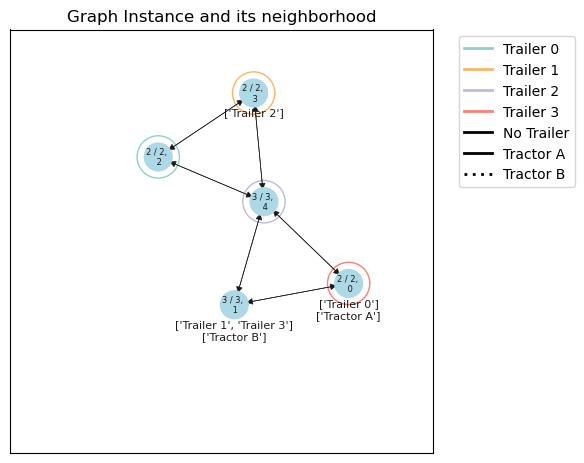

In [126]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5.5))  # Adjusted figure size
plt.title("Graph Instance and its neighborhood")

dataset.sampler.graphs[0].plot_neighbors(ax=axs, with_labels=True)
axs.set_xlim([-0.7, 1.3])
axs.set_ylim([-0.7, 1.3])
axs.set_aspect('equal')

plt.savefig(f"../images/evrp/graph_instance_{example_name}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [79]:
n_samples = 100
env = EVRP
np.random.seed(1234)
dataset = env.make_dataset(
        size=5,
        num_samples=n_samples,
        num_trucks=2,
        num_trailers=4,
        truck_names=None,
        display_graphs=3,
        r_threshold=0.6
    )
example_name="multiple"

##### Baseline

In [80]:
baseline_cost = []
baseline_ttime = []
for env, evrp_graph in zip(dataset.data, dataset.sampler.graphs):
    edges, total_time, total_cost = solve_evrp(evrp_graph.graph, env)
    baseline_cost.append(total_cost)
    baseline_ttime.append(total_time)

print(f"Baseline Length Mean: {np.mean(baseline_cost)}", f"Baseline Time Mean: {np.mean(baseline_ttime)}")

Baseline Length Mean: 4.312023940086365 Baseline Time Mean: 9.92


##### Plot Baseline Solution

In [81]:
if n_samples == 1:
    x=edges[torch.sort(edges, dim=0, descending=False)[1][:, -1]]
    # Define the range of timestamps
    timestamps = list(range(int(torch.min(x[:, -1]).item()), int(torch.max(x[:, -1]).item())+1))

    # Create an empty tensor to store the new sequence
    new_edges = torch.empty((0,5))

    # Iterate over the timestamps
    for t in timestamps:
        # Check if the timestamp exists in the tensor
        idx = (x[:, -1] == t).nonzero(as_tuple=True)
        
        if len(idx[0]) > 0:
            # If the timestamp exists, append the corresponding row to the new tensor
            new_edges = torch.cat((new_edges, x[idx]), dim=0)
        else:
            # If the timestamp does not exist, create a new row and append it to the tensor
            # The row contains the last known truck location and -1 for the trailer status
            last_truck_loc = new_edges[-1, 1]
            truck=new_edges[-1, 2]
            new_row = torch.tensor([[last_truck_loc, last_truck_loc, truck, -1., float(t)]])
            new_edges = torch.cat((new_edges, new_row), dim=0)

    for env, evrp_graph in zip(dataset.data, dataset.sampler.graphs):
        # plot graphs
        edge_count = len(new_edges) + 1

        cols = 3
        rows = math.ceil(edge_count / cols)

        fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5.5))  # Adjusted figure size
        plt.subplots_adjust(wspace=0.02, hspace=0.02)

        # Flatten axs to easily iterate over it
        axs = axs.ravel()

        evrp_graph.draw(ax=axs[0], with_labels=False)
        axs[0].set_title("Initial State")
        axs[0].set_xlim([-0.7, 1.3])
        axs[0].set_ylim([-0.7, 1.3])
        axs[0].set_aspect('equal')

        col = 1
        for edge in new_edges:
            evrp_graph.clear()
            evrp_graph.visit_edges([edge])
            evrp_graph.draw(ax=axs[col], with_labels=True)
            axs[col].set_title(f"Step {col-1}")
            axs[col].set_xlim([-0.7, 1.3])
            axs[col].set_ylim([-0.7, 1.3])
            axs[col].set_aspect('equal')

            col += 1
        
        data = edges.numpy().astype(int)
        plot_timeline(data, example_name=f"baseline_{example_name}")

        # Hide empty subplots
        for j in range(col, len(axs)):
            axs[j].axis('off')

        plt.savefig(f"../images/evrp/baseline_solution_{example_name}.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

In [82]:
def get_routes_in_timesteps(tensor):
    num_timesteps = int(tensor[:, 4].max().item()) + 1

    truck_routes = {}
    trailer_routes = {}

    # Initialize routes with first known locations
    for i in range(int(tensor[:, 2].max().item()) + 1):
        truck_routes[i] = [int(tensor[tensor[:, 2] == i][0, 0].item())]

    for i in range(int(tensor[:, 3].max().item()) + 1):
        trailer_routes[i] = [int(tensor[tensor[:, 3] == i][0, 0].item())]

    # Update routes
    for timestep in range(0, num_timesteps):
        for i in truck_routes.keys():
            mask = (tensor[:, 2] == i) & (tensor[:, 4] == timestep)
            if tensor[mask].size()[0] != 0:
                truck_routes[i].append(int(tensor[mask][0, 1].item()))
            else:
                truck_routes[i].append(truck_routes[i][-1])

        for i in trailer_routes.keys():
            mask = (tensor[:, 3] == i) & (tensor[:, 4] == timestep)
            if tensor[mask].size()[0] != 0:
                trailer_routes[i].append(int(tensor[mask][0, 1].item()))
            else:
                trailer_routes[i].append(trailer_routes[i][-1])

    return truck_routes, trailer_routes


In [83]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

if n_samples == 1:
    input = dataset[0][0]["coords"]
    distance_matrix = (input[:, None, :]-
        input[None, :, :]
    ).norm(p=2, dim=-1)

    tours_trucks_with_time, tours_trailers_with_time = get_routes_in_timesteps(new_edges)

    def find_movement_windows(tours):
        movement_windows = {}
        for trailer_id, locations in tours.items():
            windows = []
            last_location = locations[0]
            for i in range(1, len(locations)):
                if locations[i] != last_location:
                    windows.append((i - 1, i))
                    last_location = locations[i]
            movement_windows[trailer_id] = windows
        return movement_windows

    fig, ax = plt.subplots(figsize=(10, 5))

    # Define linestyles
    linestyles = ['dashed', 'dotted', 'loosely dotted', 'solid']

    # Apply hierarchical clustering (using 'average' linkage method)
    Z = linkage(distance_matrix, method='average')
    # Get the order of the nodes
    node_positions = leaves_list(Z)

    # Map node positions to labels
    node_labels = [f'Node {i}' for i in node_positions]
    node_position_to_label = {pos: label for pos, label in zip(node_positions, node_labels)}

    colors = get_trailer_colors(len(tours_trailers_with_time) + 1)

    # Plot all points for trucks and trailers
    for truck_idx, truck_route in enumerate(tours_trucks_with_time.values()):
        y_values = [node_positions.tolist().index(node) for node in truck_route]
        # ax.scatter(range(len(y_values)), [x-0.15 for x in y_values], color='black', marker='o', alpha=0.9)
        ax.plot(y_values, linestyle=linestyles[truck_idx % len(linestyles)], color='black', alpha=0.7,
                label=f'Tractor {truck_idx}', linewidth=1.2)

    time_windows = find_movement_windows(tours_trailers_with_time)
    # Plot trailer routes within time windows
    for trailer_idx, trailer_route in enumerate(tours_trailers_with_time.values()):
        for window_start, window_end in time_windows[trailer_idx]:
            y_values_window = [node_positions.tolist().index(node) for node in trailer_route[window_start:window_end + 1]]
            ax.plot([x for x in range(window_start, window_end + 1)], y_values_window, linestyle='-', marker="o",
                    linewidth=5, color=colors[trailer_idx], alpha=0.4, label=f'Trailer {trailer_idx}')

    # Set plot labels
    ax.set_title('Routes', fontdict={"fontsize": "20"})
    ax.set_xlabel('Steps', fontdict={"fontsize": "18"})
    # ax.set_ylabel('Node', fontdict={"fontsize":"18"})

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1, 1), fontsize=16)

    ax.set_yticks(range(len(node_positions)))
    ax.set_yticklabels(node_labels, fontsize=14)

    # add grid
    ax.grid(True, linewidth=0.1)
    # set xticks to be integers
    num_steps = len(next(iter(tours_trucks_with_time.values())))
    ax.set_xticks(np.arange(num_steps))
    ax.set_xticklabels(np.arange(num_steps), fontsize=14)

    plt.tight_layout()
    plt.savefig(f"../images/evrp/route_baseline_{example_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

##### Model

In [84]:
# # reset
# env = EVRP
# dataset = env.make_dataset(
#         filename='../instances/paper_5_nodes_swapping.json',
#         r_threshold=0.6
#     )
# n_samples=1
# example_name="paper5"
# plt.rcdefaults()

In [85]:
# model, _ = load_model('../../outputs/evrp_5/rollout_20230725T213940') # model to compare with the other epochs 30 without extra costs
# model, _ = load_model('../../outputs/evrp_5/rollout_20230804T020006/epoch-14.pt') # changed cost function model to compare (normal reward func)
# model, _ = load_model('../../outputs/evrp_5/rollout_20230806T115541/epoch-21.pt') # changed cost function model to compare (normal reward func) NAdam
# model, _ = load_model('../../runs/evrp_5/rollout_20230814T133525/epoch-57.pt') # changed cost function model to compare (normal reward func) / NAdam

model, _ = load_model('../model') # changed cost function model to compare (normal reward func) / NAdam

  [*] Loading model from ../model/epoch-50.pt


In [86]:
def collate_fn(batch):
    data_batch, graph_batch = zip(*batch)

    return default_collate(data_batch), list(graph_batch)


In [87]:
def tensor_to_tuples(tensor):
    batch_size, features, time = tensor.shape
    edges = []
    for b in range(batch_size):
        batch_list = tuple(tensor[b, :, time - 1].tolist())
        edges.append([batch_list])

    return edges

In [88]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=n_samples, collate_fn=collate_fn)

# Make var works for dicts
batch = next(iter(dataloader))
# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    cost, length, reward, penalty, _, edges_model, decision_model = model(batch[0].copy(), batch[1].copy(), return_pi=True)

edges_model=edges_model.permute(1,2,0)
decision_model=decision_model.permute(0, 2, 1)

Finished Batches 91/100
Length:  tensor(8.7092) Penalty:  tensor(10.6800, dtype=torch.float64)
Reward:  tensor(1.2693, dtype=torch.float64)


In [89]:
edges_model.shape

torch.Size([100, 313, 5])

In [90]:
model_times = []
for i, env in enumerate(dataset.data):
    data = edges_model[i].numpy().astype(int)
    print("Cost: ", cost[i].item(), "Length: ", length[i].item(), "Total Time: ", data[-1][-1], f"Reward: {reward[i].item()}", f"Penalty: {penalty[i].item()}")
    model_times.append(data[-1][-1])
    # plot_timeline(data)

    model_length = length.mean()
    model_cost = cost.mean()
    model_ttime = np.array(model_times).mean()

Cost:  9.348485730588436 Length:  9.825746536254883 Total Time:  18 Reward: 0.4772608056664467 Penalty: 0.0
Cost:  3.3070322945713997 Length:  4.3824639320373535 Total Time:  9 Reward: 1.0754316374659538 Penalty: 0.0
Cost:  3.3203598335385323 Length:  4.154705047607422 Total Time:  10 Reward: 0.8343452140688896 Penalty: 0.0
Cost:  156.47612217068672 Length:  2.794952869415283 Total Time:  312 Reward: 0.3188306987285614 Penalty: 154.0
Cost:  0.6125115603208542 Length:  4.326382160186768 Total Time:  8 Reward: 3.7138705998659134 Penalty: 0.0
Cost:  156.2388303950429 Length:  5.728285789489746 Total Time:  312 Reward: 0.4894553944468498 Penalty: 151.0
Cost:  3.6678790524601936 Length:  4.461151123046875 Total Time:  7 Reward: 0.7932720705866814 Penalty: 0.0
Cost:  1.5221081003546715 Length:  4.151220321655273 Total Time:  7 Reward: 2.629112221300602 Penalty: 0.0
Cost:  4.79794380068779 Length:  5.334544658660889 Total Time:  9 Reward: 0.5366008579730988 Penalty: 0.0
Cost:  4.1719786003232

##### Plot Model Solution

In [91]:
if n_samples == 1:
    for i, (env, evrp_graph) in enumerate(zip(dataset.data, dataset.sampler.graphs)):
        # plot graphs
        edge_count = len(edges_model[i]) + 1

        cols = 3
        rows = math.ceil(edge_count / cols)

        fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5.5))  # Adjusted figure size
        plt.subplots_adjust(wspace=0.02, hspace=0.02)

        # Flatten axs to easily iterate over it
        axs = axs.ravel()

        evrp_graph.draw(ax=axs[0], with_labels=False)
        axs[0].set_title("Initial State")
        axs[0].set_xlim([-0.7, 1.3])
        axs[0].set_ylim([-0.7, 1.3])
        axs[0].set_aspect('equal')

        col = 1
        for edge in edges_model[i]:
            evrp_graph.clear()
            evrp_graph.visit_edges([edge])
            evrp_graph.draw(ax=axs[col], with_labels=True)
            axs[col].set_title(f"Step {col-1}")
            axs[col].set_xlim([-0.7, 1.3])
            axs[col].set_ylim([-0.7, 1.3])
            axs[col].set_aspect('equal')

            col += 1

        data = edges_model[i].numpy().astype(int)
        plot_timeline(data, example_name=example_name)

        # Hide empty subplots
        for j in range(col, len(axs)):
            axs[j].axis('off')

        plt.savefig(f"../images/evrp/plot_solution_baseline{example_name}.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

##### Display Data

In [92]:
np.array(baseline_cost).mean(), np.array(baseline_ttime).mean()

(4.312023940086365, 9.92)

In [93]:
baseline_cost, baseline_ttime

([7.263076305389404,
  3.0142405033111572,
  3.0636682510375977,
  3.9385876655578613,
  3.7798538208007812,
  4.711589813232422,
  4.461151123046875,
  3.1221022605895996,
  4.804460525512695,
  3.54215407371521,
  3.771120309829712,
  6.7326812744140625,
  3.022399425506592,
  8.293746948242188,
  4.346357822418213,
  5.553314208984375,
  4.433529853820801,
  5.325064182281494,
  3.8039748668670654,
  4.295619010925293,
  2.3347043991088867,
  3.7762207984924316,
  4.439894199371338,
  3.9542040824890137,
  2.7233495712280273,
  6.329698085784912,
  3.6822094917297363,
  4.2534685134887695,
  3.761223554611206,
  4.169599533081055,
  4.6054840087890625,
  3.6488335132598877,
  7.49839973449707,
  3.0545763969421387,
  3.1189846992492676,
  2.679414749145508,
  3.1458113193511963,
  3.359804153442383,
  4.642729759216309,
  4.913887977600098,
  4.822520732879639,
  6.6514506340026855,
  3.250936985015869,
  2.333944082260132,
  5.3486008644104,
  5.800203323364258,
  4.942943572998047

In [94]:
model_cost, model_length, model_ttime

(tensor(18.1199, dtype=torch.float64), tensor(8.7092), 36.98)

In [95]:
length, cost, model_times

(tensor([  9.8257,   4.3825,   4.1547,   2.7950,   4.3264,   5.7283,   4.4612,
           4.1512,   5.3345,   5.1690,   4.2737,   9.7198,   3.9701, 164.7006,
           4.3519,   6.6021,   4.9931,   5.3251,   4.8684,   4.9111,   3.9438,
           6.0107,   6.6905,   5.9791,   3.8918,   7.3440,   6.2297,   5.6079,
           4.2317,   4.5797,   6.6502,   4.6642,   9.6423,   3.1888,   3.1302,
           3.2471,   3.7256,   4.7901,   6.8847,   9.7734,   9.1928,   7.6990,
           2.9542,   5.4056,   6.9104,   7.4519,   5.1277,   4.7879,   5.4801,
           7.3201,   7.6997,   3.3624,   5.5043,   4.3277,   4.3071,   5.7862,
           3.3133,   4.7613,   4.3694,   5.5467,   3.9768,   5.8049,   3.8056,
         178.5964,   3.4520,   3.7922,   5.3434,   3.3210,   5.6711,   6.9639,
           4.5166,   4.3868,   8.5078,   4.7547,   4.5999,   5.8349,   7.5141,
           5.7358,   6.3420,   8.2544,   6.5550,   5.0412,   5.2778,   5.7805,
           5.9592,   3.6880,   5.2017,   6.4528,   5

##### Plot Analysis Data

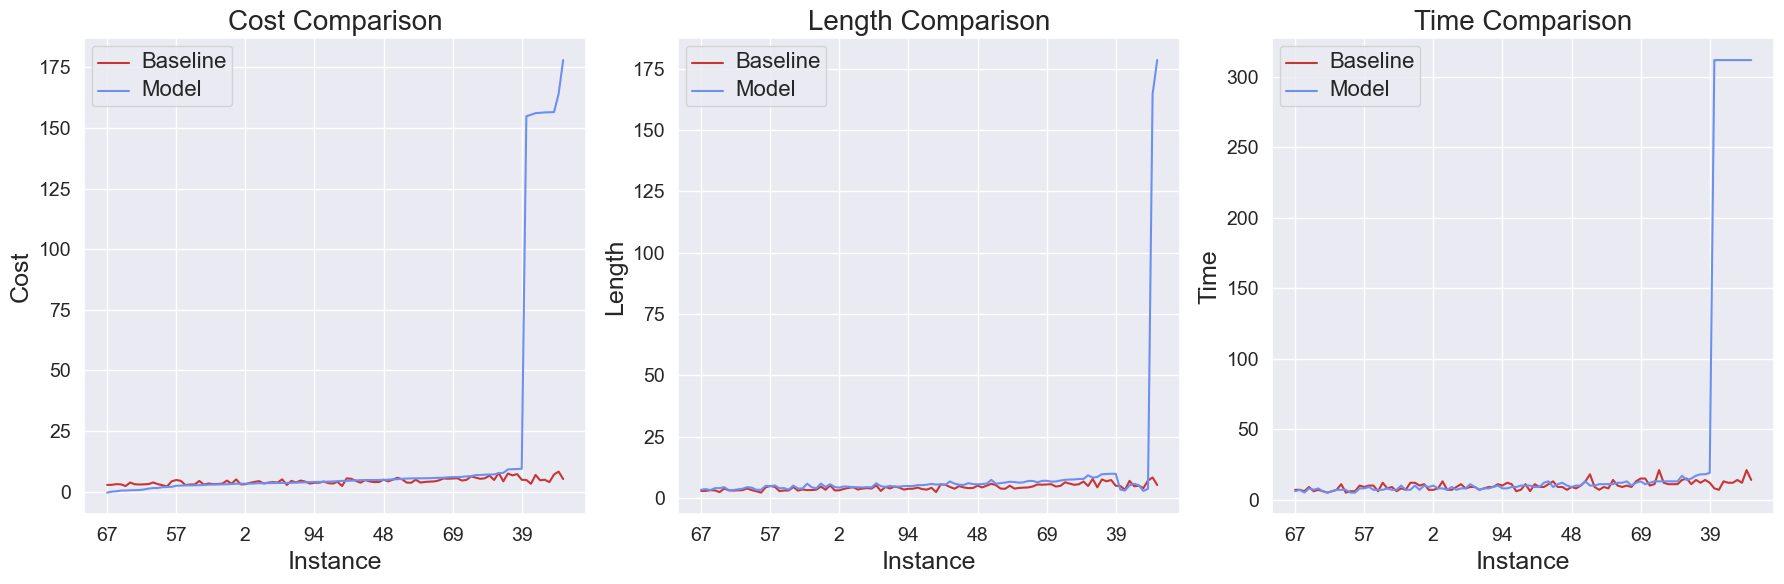

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_theme("notebook")

instances = [str(i) for i in range(len(baseline_cost))]

df_costs = pd.DataFrame({
    'Instance': instances,
    'Baseline': baseline_cost,
    'Model': list(cost.numpy()),
})
# Sort the df_lengths dataframe based on 'Baseline'
df_costs = df_costs.sort_values(by='Model')
# Extract the order of instances
ordered_instances = df_costs['Instance'].tolist()
df_costs['Instance'] = pd.Categorical(df_costs['Instance'], categories=ordered_instances, ordered=True)
df_costs = df_costs.sort_values('Instance')
# df_costs = df_costs[df_costs['Model']<=100]

# Create a dataframe
df_lengths = pd.DataFrame({
    'Instance': instances,
    'Baseline': baseline_cost,
    'Model': list(length.numpy()),
})
# Apply the order to df_times (or any other dataframe)
df_lengths['Instance'] = pd.Categorical(df_lengths['Instance'], categories=ordered_instances, ordered=True)
df_lengths = df_lengths.sort_values('Instance')
# df_lengths = df_lengths[df_lengths['Model']<=100]

df_times = pd.DataFrame({
    'Instance': instances,
    'Baseline': baseline_ttime,
    'Model': model_times,
})
df_times['Instance'] = pd.Categorical(df_times['Instance'], categories=ordered_instances, ordered=True)
df_times = df_times.sort_values('Instance')
# df_times = df_times[df_times['Model']<=100]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
colors = plt.cm.coolwarm(np.linspace(0, 1, 20))

# Create a new figure for the cost comparison
plot_i = 0
# Adjust the xticks' label size
axs[plot_i].tick_params(labelsize=14)
sns.lineplot(x='Instance', y='value', hue='variable',
             data=pd.melt(df_costs, ['Instance']), ax=axs[plot_i], palette=[colors[18], colors[3]])
axs[plot_i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # set y-axis ticks to be integers
axs[plot_i].set_title('Cost Comparison', size=20)
axs[plot_i].set_xlabel('Instance', size=18)
axs[plot_i].set_ylabel('Cost', size=18)
# axs[0].legend()
for text in axs[plot_i].legend().get_texts():
    text.set_fontsize(16)

# Create a new figure for the length comparison
plot_i = 1
# Adjust the xticks' label size
axs[plot_i].tick_params(labelsize=14)
sns.lineplot(x='Instance', y='value', hue='variable',
             data=pd.melt(df_lengths, ['Instance']), ax=axs[plot_i], palette=[colors[18], colors[3]])
axs[plot_i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # set y-axis ticks to be integers
axs[plot_i].set_title('Length Comparison', size=20)
axs[plot_i].set_xlabel('Instance', size=18)
axs[plot_i].set_ylabel('Length', size=18)
# axs[0].legend()
for text in axs[plot_i].legend().get_texts():
    text.set_fontsize(16)

plot_i = 2
# Adjust the xticks' label size
axs[plot_i].tick_params(labelsize=14)
sns.lineplot(x='Instance', y='value', hue='variable',
             data=pd.melt(df_times, ['Instance']), ax=axs[plot_i], palette=[colors[18], colors[3]])
axs[plot_i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # set y-axis ticks to be integers
axs[plot_i].set_ylabel('Time', size=18)
axs[plot_i].set_xlabel('Instance', size=18)
axs[plot_i].set_title('Time Comparison', size=20)
# axs[1].legend()
for text in axs[plot_i].legend().get_texts():
    text.set_fontsize(16)

# Display plot
plt.tight_layout()
plt.savefig("../images/evrp/plot_basic_algorithm_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [110]:
sum(df_costs["Model"] < df_costs["Baseline"] ), sum(df_costs["Model"] == df_costs["Baseline"] ), sum(df_costs["Model"] > df_costs["Baseline"] )

(47, 0, 53)

In [111]:
sum(df_lengths["Model"] < df_lengths["Baseline"] ), sum(df_lengths["Model"] == df_lengths["Baseline"] ), sum(df_lengths["Model"] > df_lengths["Baseline"] ),

(6, 3, 91)

In [113]:
sum(df_times["Model"] < df_times["Baseline"] ),  sum(df_times["Model"] == df_times["Baseline"] ), sum(df_times["Model"] > df_times["Baseline"] ), 

(34, 18, 48)